In [24]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sparselt.esmf
import sparselt.xr
import mf2w
from tqdm.dask import TqdmCallback

C:\Users\liamb\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
#tavg_1hr_ctm = xr.open_dataset("data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0030.V01.nc4")
with TqdmCallback(desc="compute"):
    tavg_3hr_ctm = xr.open_mfdataset(["data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0030.V01.nc4",
                                    "data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0130.V01.nc4",
                                    "data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0230.V01.nc4"], data_vars=['MFXC', 'MFYC', 'DELP'], compat='override', coords=['time'])
    tavg_3hr_ctm = tavg_3hr_ctm.drop(['cubed_sphere', 'contacts', 'orientation', 'anchor', 'TAITIME', 'PS'])
    tavg_3hr_ctm = tavg_3hr_ctm.mean(dim=['time']).expand_dims(dim='time', axis=0)
    tavg_3hr_ctm.compute()
grid = xr.open_mfdataset([f"data/c720.tile{n}.nc" for n in range(1,7)], concat_dim='nf', combine='nested')
tavg_1hr_winds = mf2w.convert_mass_fluxes_to_wind(tavg_3hr_ctm, grid, change_of_basis='ronchi')

Processing: 100%|██████████| 6/6 [14:46<00:00, 147.68s/cube_sphere_face]


In [26]:
transform = sparselt.esmf.load_weights(
    'data/weights_cs2ll.nc',
    input_dims=[('nf', 'Ydim', 'Xdim'), (6, 720, 720)],
    output_dims=[('lat', 'lon'), (721, 1152)],
)
tavg_1hr_winds_ll = sparselt.xr.apply(transform, tavg_1hr_winds)

In [27]:
latlon_grid = xr.open_dataset("data/regular_lat_lon_721x1152.nc")
tavg3_3d_asm = xr.open_dataset("data/GEOS.fp.asm.tavg3_3d_asm_Nv.20210401_0130.V01.nc4")
x = latlon_grid.lon
y = latlon_grid.lat

RMSE: 0.9644398215228333
RMSE: 0.9834873116535643
RMSE: 0.37730930984684663


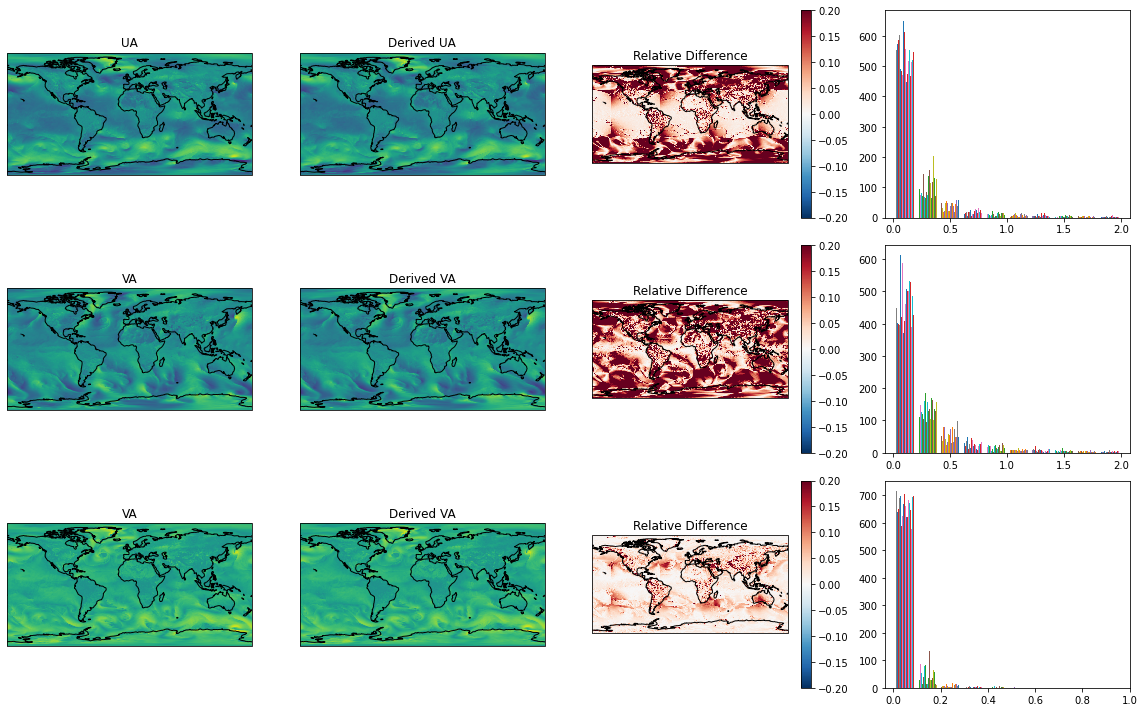

In [28]:
%matplotlib inline

norm = plt.Normalize(-30, 30)

plt.figure(figsize=(16,10))


expected=tavg3_3d_asm.U[0,-1,:,:]
calculated=tavg_1hr_winds_ll.UA[0,-1,:,:]
relative_difference = np.abs(calculated-expected)/np.maximum(np.abs(calculated), np.abs(expected))
rmse = np.sqrt(np.mean((calculated-expected)**2)).item()
print(f"RMSE: {rmse}")

ax = plt.subplot(3,4,1, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("UA")
plt.pcolormesh(x, y, expected, norm=norm)

ax = plt.subplot(3,4,2, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Derived UA")
plt.pcolormesh(x, y, calculated, norm=norm)

ax = plt.subplot(3,4,3, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Relative Difference")
plt.pcolormesh(x, y, relative_difference, norm=plt.Normalize(-0.2, 0.2), cmap='RdBu_r')
plt.colorbar()

ax = plt.subplot(3,4,4)
plt.hist(relative_difference)

expected=tavg3_3d_asm.V[0,-1,:,:]
calculated=tavg_1hr_winds_ll.VA[0,-1,:,:]
relative_difference = np.abs(calculated-expected)/np.maximum(np.abs(calculated), np.abs(expected))
rmse = np.sqrt(np.mean((calculated-expected)**2)).item()
print(f"RMSE: {rmse}")

ax = plt.subplot(3,4,5, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("VA")
plt.pcolormesh(x, y, expected, norm=norm)

ax = plt.subplot(3,4,6, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Derived VA")
plt.pcolormesh(x, y, calculated, norm=norm)

ax = plt.subplot(3,4,7, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Relative Difference")
plt.pcolormesh(x, y, relative_difference, norm=plt.Normalize(-0.2, 0.2), cmap='RdBu_r')
plt.colorbar()

ax = plt.subplot(3,4,8)
plt.hist(relative_difference)

expected=np.sqrt(tavg3_3d_asm.U[0,-1,:,:]**2 + tavg3_3d_asm.V[0,-1,:,:]**2)
calculated=np.sqrt(tavg_1hr_winds_ll.UA[0,-1,:,:]**2 + tavg_1hr_winds_ll.VA[0,-1,:,:]**2)
relative_difference = np.abs(calculated-expected)/np.maximum(np.abs(calculated), np.abs(expected))
rmse = np.sqrt(np.mean((calculated-expected)**2)).item()
print(f"RMSE: {rmse}")

ax = plt.subplot(3,4,9, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("VA")
plt.pcolormesh(x, y, expected, norm=norm)

ax = plt.subplot(3,4,10, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Derived VA")
plt.pcolormesh(x, y, calculated, norm=norm)

ax = plt.subplot(3,4,11, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Relative Difference")
plt.pcolormesh(x, y, relative_difference, norm=plt.Normalize(-0.2, 0.2), cmap='RdBu_r')
plt.colorbar()

ax = plt.subplot(3,4,12)
plt.hist(relative_difference)

plt.tight_layout()

In [20]:
tavg_3hr_ctm.MFXC.expand_dims(dim='time', axis=0)

<xarray.DataArray 'MFXC' (time: 1, lev: 72, nf: 6, Ydim: 720, Xdim: 720)>
dask.array<broadcast_to, shape=(1, 72, 6, 720, 720), dtype=float32, chunksize=(1, 72, 6, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * nf       (nf) int32 1 2 3 4 5 6
  * Xdim     (Xdim) float64 -54.95 -54.84 -54.74 -54.64 ... 34.74 34.84 34.95
  * Ydim     (Ydim) float64 -44.95 -44.84 -44.74 -44.64 ... 44.74 44.84 44.95
    lons     (nf, Ydim, Xdim) float64 dask.array<chunksize=(6, 720, 720), meta=np.ndarray>
    lats     (nf, Ydim, Xdim) float64 dask.array<chunksize=(6, 720, 720), meta=np.ndarray>
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
Dimensions without coordinates: time

In [21]:
tavg_3hr_ctm.expand_dims(dim='time', axis=0)

<xarray.Dataset>
Dimensions:   (nf: 6, ncontact: 4, Xdim: 720, Ydim: 720, lev: 72, time: 1)
Coordinates:
  * nf        (nf) int32 1 2 3 4 5 6
  * ncontact  (ncontact) int32 1 2 3 4
  * Xdim      (Xdim) float64 -54.95 -54.84 -54.74 -54.64 ... 34.74 34.84 34.95
  * Ydim      (Ydim) float64 -44.95 -44.84 -44.74 -44.64 ... 44.74 44.84 44.95
    lons      (nf, Ydim, Xdim) float64 dask.array<chunksize=(6, 720, 720), meta=np.ndarray>
    lats      (nf, Ydim, Xdim) float64 dask.array<chunksize=(6, 720, 720), meta=np.ndarray>
  * lev       (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
Dimensions without coordinates: time
Data variables:
    CX        (time, lev, nf, Ydim, Xdim) float32 dask.array<chunksize=(1, 72, 6, 720, 720), meta=np.ndarray>
    CY        (time, lev, nf, Ydim, Xdim) float32 dask.array<chunksize=(1, 72, 6, 720, 720), meta=np.ndarray>
    DELP      (time, lev, nf, Ydim, Xdim) float32 dask.array<chunksize=(1, 72, 6, 720, 720), meta=np.ndarray>
    MFXC      (time, lev, nf, Ydim, Xdim) float32 dask.array<chunksize=(1, 72, 6, 720, 720), meta=np.ndarray>
    MFYC      (time, lev, nf, Ydim, Xdim) float32 dask.array<chunksize=(1, 72, 6, 720, 720), meta=np.ndarray>